# Introduction

## Sales Forecasting Model Using Prophet

This repository contains a base sales forecasting model built in Python using the Prophet library. The model is designed to forecast weekly sales data by capturing trends and seasonal patterns inherent in the data. In this implementation, Prophet is used to automatically detect changepoints and seasonality, while also allowing the inclusion of external regressors (such as key advertising metrics) to enhance forecast accuracy.

◼️ Model Building
- Prophet Model:
A base Prophet model is constructed with built-in functionalities for trend and seasonality detection.
- External Regressors:
Key advertising variables are added as regressors to allow the model to account for their impact on sales. These regressors are integrated before model fitting, ensuring that their influence is captured in the forecast.

◾️ Model Evaluation
- Train/Test Split:
The “Actual” sales data is split into training and testing sets. The model is trained on the training set and then evaluated on the test set using metrics such as RMSE, MAE, and MAPE.

◾️ Forecasting
- Future Predictions:
After validating the model, it is applied to forecast future sales for a specified period. The forecasted values are output and visualized alongside the historical data.

◾️ Overall Insight
- Although the predictive accuracy of this base model may be moderate, it provides a solid framework for understanding time series forecasting using Prophet. 
- The model’s structure, including the integration of external regressors, offers a clear pathway for further refinement and enhancement in future iterations.

In [1]:
import numpy as np
import pandas as pd
import datetime

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.model_selection import train_test_split

import optuna
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot')  
plt.rcParams['figure.figsize'] = [12, 9]  
plt.rcParams['font.size'] = 14           

In [2]:
dataset ="../data/sales_data.csv"
df = pd.read_csv(dataset)

# Preprocess

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y', errors='coerce')

df['Sales'] = pd.to_numeric(df['Sales'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Digital_Ads'] = pd.to_numeric(df['Digital_Ads'].str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['Offline_Ads'] = pd.to_numeric(df['Offline_Ads'].astype(str).str.replace(',', ''), errors='coerce').fillna(0).astype('int64')
df['TVCM_GPR'] = pd.to_numeric(df['TVCM_GPR'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
df['Print_Media'] = pd.to_numeric(df['Print_Media'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         121 non-null    datetime64[ns]
 1   Sales        121 non-null    int64         
 2   TVCM_GPR     121 non-null    float64       
 3   Print_Media  121 non-null    int64         
 4   Offline_Ads  121 non-null    int64         
 5   Digital_Ads  121 non-null    int64         
 6   Record_Type  121 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 6.7+ KB


In [4]:
df_actual = df[df['Record_Type'] == "Actual"].copy()
df_forecast = df[df['Record_Type'] == "Forecast"].copy()

In [5]:
df_actual = df_actual.reset_index()[["Date", "Sales","Digital_Ads", "Offline_Ads","TVCM_GPR", "Print_Media"]]
df_forecast = df_forecast.reset_index()[["Date", "Sales","Digital_Ads", "Offline_Ads","TVCM_GPR", "Print_Media"]]

In [6]:
df_actual = df_actual.rename(columns={"Date": "ds", "Sales": "y"})
df_forecast = df_forecast.rename(columns={"Date": "ds", "Sales": "y"})


In [7]:
df_actual


,ds,y,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
0,2015-09-07,5554981,23080,5890000,58.86750,20340000
1,2015-09-14,6071669,29979,5740000,235.18125,15470000
2,2015-09-21,5798657,23784,0,252.18375,8325000
3,2015-09-28,6235157,26732,0,75.25500,0
4,2015-10-05,6861105,28823,0,0.00000,0
...,...,...,...,...,...,...
100,2017-08-07,9382929,73930,0,0.00000,19180000
101,2017-08-14,6424589,51122,0,0.00000,12785000
102,2017-08-21,5308052,45519,0,39.29250,12510000
103,2017-08-28,5637103,33703,0,0.00000,12890000


# Test Train Split

In [8]:
train, test = train_test_split(df_actual, test_size=12)
print("Train shape:", train.shape)
print("Test shape :", test.shape)

Train shape: (93, 6)
Test shape : (12, 6)


In [9]:
train

,ds,y,Digital_Ads,Offline_Ads,TVCM_GPR,Print_Media
0,2015-09-07,5554981,23080,5890000,58.86750,20340000
1,2015-09-14,6071669,29979,5740000,235.18125,15470000
2,2015-09-21,5798657,23784,0,252.18375,8325000
3,2015-09-28,6235157,26732,0,75.25500,0
4,2015-10-05,6861105,28823,0,0.00000,0
...,...,...,...,...,...,...
88,2017-05-15,5495377,29060,0,0.00000,0
89,2017-05-22,6490125,39689,19680000,48.51000,0
90,2017-05-29,6029318,117831,27850000,377.59500,12345000
91,2017-06-05,7888141,84239,0,347.74125,13170000


# Visualize the Test / Train Data

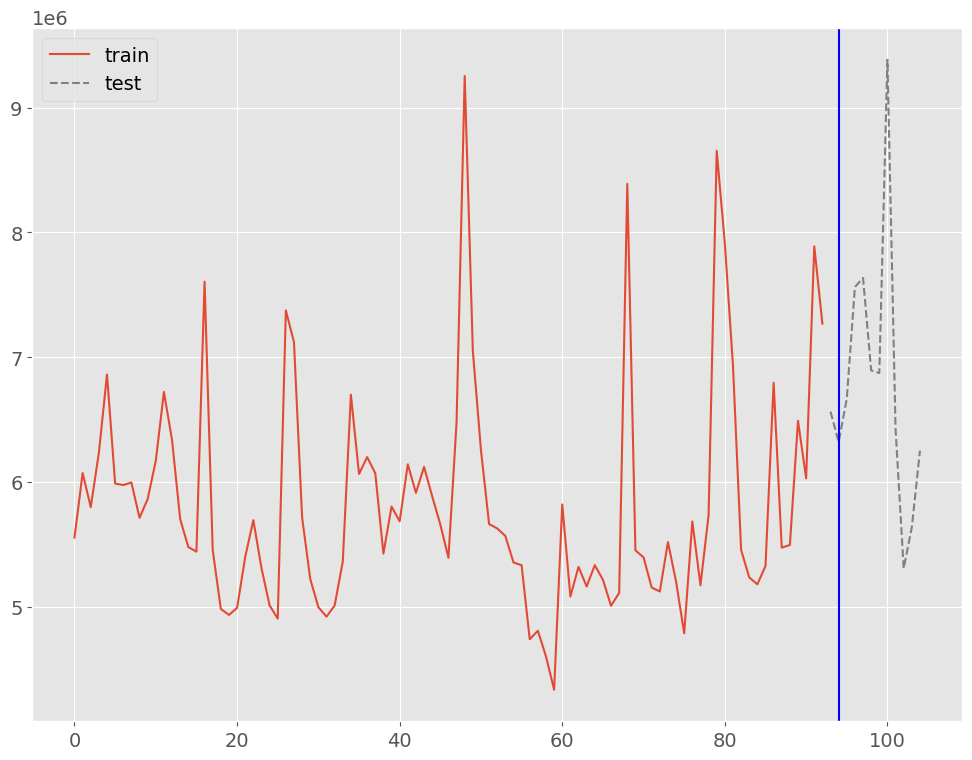

In [10]:
fig, ax = plt.subplots()

ax.plot(
    train.index,
    train.y.values,
    linestyle='-',
    label='train'
)

ax.plot(
    test.index,
    test.y.values,
    linestyle='--',
    label='test',
    color='gray'
)

ax.axvline(
    94,
    color='blue')
ax.legend()
plt.show()

In [11]:
def objective(trial):
    """ Objective function to optimize Prophet hyperparams via test RMSE. """
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 1.0, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 10.0, log=True)
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])
    
    model_trial = Prophet(
        weekly_seasonality=True,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode
    )
    model_trial.add_regressor("Digital_Ads")
    model_trial.add_regressor("Offline_Ads")
    model_trial.add_regressor("TVCM_GPR")
    model_trial.add_regressor("Print_Media")
    
    model_trial.fit(train)
    
    test_pred_df = model_trial.predict(test)
    test_pred = test_pred_df['yhat'].values
    
    rmse = np.sqrt(mean_squared_error(test['y'], test_pred))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # e.g. 30 trials

best_params = study.best_params
best_value = study.best_value
print("\n--- Optuna Best Params ---")
print(best_params)
print("Best RMSE:", best_value)

[I 2025-03-13 11:54:36,554] A new study created in memory with name: no-name-6848fab5-b159-4379-929e-4987b657a848
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:36,771] Trial 0 finished with value: 774927.4733632243 and parameters: {'changepoint_prior_scale': 0.0027499426350910934, 'seasonality_prior_scale': 1.8326665334667944, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 774927.4733632243.
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:36,868] Trial 1 finished with value: 789338.1210732901 and parameters: {'changepoint_prior_scale': 0.008000690568002119, 'seasonality_prior_scale': 0.08906942772648707, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 774927.4733632243.
11:54:36 - cmdstanpy - INFO - Chain [1] start processing
11:54:36 - cmdstanpy - INFO - Chain [1] done processing
[I 

11:54:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:41,358] Trial 21 finished with value: 754455.2569747929 and parameters: {'changepoint_prior_scale': 0.6662864343659313, 'seasonality_prior_scale': 4.9277445179655865, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 754455.2569747929.
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:41,598] Trial 22 finished with value: 762561.5087311341 and parameters: {'changepoint_prior_scale': 0.5529329667319678, 'seasonality_prior_scale': 5.951624185855918, 'seasonality_mode': 'additive'}. Best is trial 21 with value: 754455.2569747929.
11:54:41 - cmdstanpy - INFO - Chain [1] start processing
11:54:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:41,974] Trial 23 finished with value: 762564.4219472528 and parameters: {'changepoint_prior_scale': 0.18885326212504766, 'seasonality_prior_scale': 5.2281490977545

11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:47,471] Trial 43 finished with value: 750792.635583332 and parameters: {'changepoint_prior_scale': 0.7546503707874604, 'seasonality_prior_scale': 6.65659915534237, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 750792.635583332.
11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:47,765] Trial 44 finished with value: 761358.8315313254 and parameters: {'changepoint_prior_scale': 0.9578702466936101, 'seasonality_prior_scale': 6.060621592536786, 'seasonality_mode': 'additive'}. Best is trial 43 with value: 750792.635583332.
11:54:47 - cmdstanpy - INFO - Chain [1] start processing
11:54:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:47,852] Trial 45 finished with value: 774160.9518568107 and parameters: {'changepoint_prior_scale': 0.002847180

11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:52,719] Trial 65 finished with value: 765480.1496006984 and parameters: {'changepoint_prior_scale': 0.5271355160964102, 'seasonality_prior_scale': 0.038102941150848786, 'seasonality_mode': 'additive'}. Best is trial 61 with value: 750263.067564597.
11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:52,937] Trial 66 finished with value: 750851.1433998256 and parameters: {'changepoint_prior_scale': 0.7548152035918885, 'seasonality_prior_scale': 9.731102308389463, 'seasonality_mode': 'additive'}. Best is trial 61 with value: 750263.067564597.
11:54:52 - cmdstanpy - INFO - Chain [1] start processing
11:54:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:53,274] Trial 67 finished with value: 763460.0537804672 and parameters: {'changepoint_prior_scale': 0.9950

11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:58,819] Trial 87 finished with value: 752423.9856734793 and parameters: {'changepoint_prior_scale': 0.6958490529605325, 'seasonality_prior_scale': 8.292535189148825, 'seasonality_mode': 'multiplicative'}. Best is trial 61 with value: 750263.067564597.
11:54:58 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:59,098] Trial 88 finished with value: 754283.8728903605 and parameters: {'changepoint_prior_scale': 0.841816051690906, 'seasonality_prior_scale': 6.653352090210519, 'seasonality_mode': 'additive'}. Best is trial 61 with value: 750263.067564597.
11:54:59 - cmdstanpy - INFO - Chain [1] start processing
11:54:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2025-03-13 11:54:59,315] Trial 89 finished with value: 771088.2042735369 and parameters: {'changepoint_prior_scale': 0.31


--- Optuna Best Params ---
{'changepoint_prior_scale': 0.7756572099380674, 'seasonality_prior_scale': 3.4059131854039593, 'seasonality_mode': 'additive'}
Best RMSE: 750263.067564597


# Model Building

In [12]:
final_model = Prophet(
    weekly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
final_model.add_regressor("Digital_Ads")
final_model.add_regressor("Offline_Ads")
final_model.add_regressor("TVCM_GPR")
final_model.add_regressor("Print_Media")

final_model.fit(train)

11:55:01 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
test_pred_df = final_model.predict(test)
test_pred = test_pred_df['yhat'].values

rmse = np.sqrt(mean_squared_error(test['y'], test_pred))
mae = mean_absolute_error(test['y'], test_pred)
mape = mean_absolute_percentage_error(test['y'], test_pred)
print(f"\n--- Final Model Test Evaluation ---")
print("RMSE:", rmse)
print("MAE: ", mae)
print("MAPE:", mape)


--- Final Model Test Evaluation ---
RMSE: 750263.067564597
MAE:  455667.51961995265
MAPE: 0.06157708629528424


In [14]:
forecast_pred_df = final_model.predict(df_forecast)

print("\n--- Forecast (Future) Results ---")
print(forecast_pred_df[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())



--- Forecast (Future) Results ---
          ds          yhat    yhat_lower    yhat_upper
0 2017-09-11  5.656598e+06  4.887213e+06  6.385935e+06
1 2017-09-18  5.772180e+06  4.995309e+06  6.581919e+06
2 2017-09-25  5.470977e+06  4.635215e+06  6.265474e+06
3 2017-10-02  5.490717e+06  4.702414e+06  6.286164e+06
4 2017-10-09  5.398180e+06  4.606554e+06  6.169245e+06


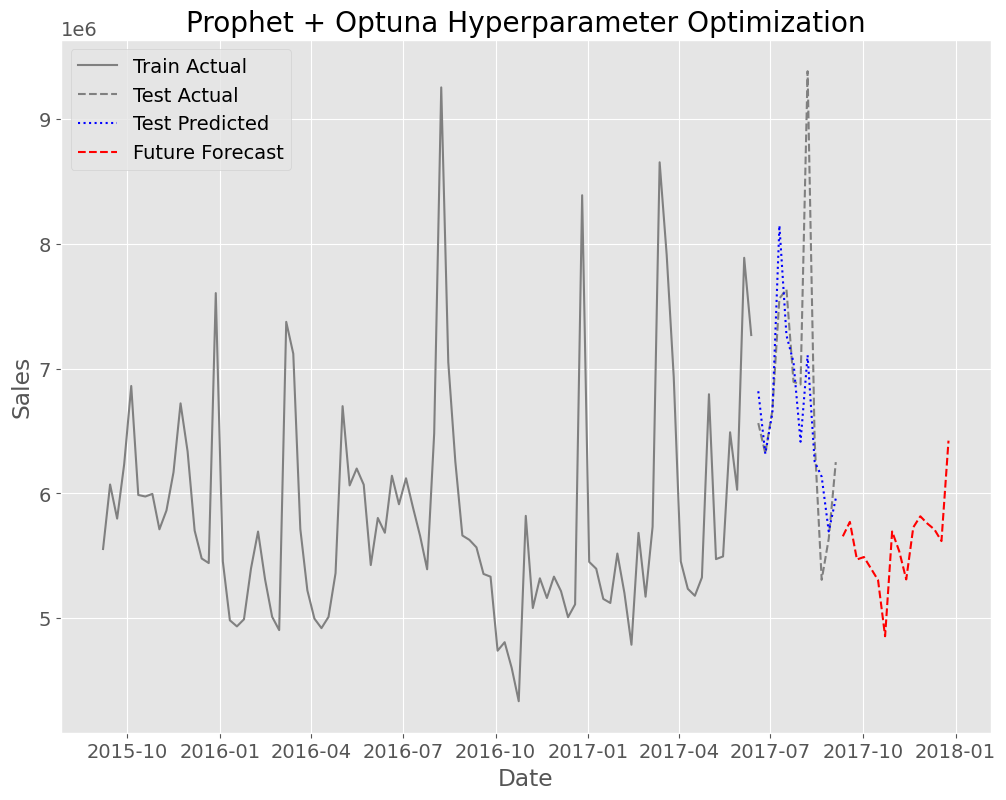

In [15]:
fig, ax = plt.subplots()

ax.plot(train['ds'], train['y'], label='Train Actual', color='gray')

ax.plot(test['ds'], test['y'], label='Test Actual', linestyle='--', color='gray')

ax.plot(test['ds'], test_pred, label='Test Predicted', linestyle=':', color='blue')

ax.plot(forecast_pred_df['ds'], forecast_pred_df['yhat'],
        label='Future Forecast', linestyle='--', color='red')

ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.set_title("Prophet + Optuna Hyperparameter Optimization")
ax.legend()
plt.show()

# Result

These metrics indicate the model’s performance on the held‐out test set:

- RMSE (~751,574):
On average, the model’s predictions deviate from the true sales by roughly 752k, putting more weight on larger individual errors due to the nature of squaring residuals.

- MAE (~457,058):
The mean absolute error is around 457k, suggesting that, on average, the forecast differs from actual sales by about 457k in absolute terms.

- MAPE (~6.17%):
The model’s predictions are, on average, within about 6.2% of the real sales values. This is a fairly strong result from a relative error perspective, depending on the business context.

Overall, an MAPE of around 6% generally indicates a relatively good forecast accuracy (again, contingent on how large your typical sales are). The absolute errors (RMSE/MAE) are reminders of the actual margin of deviation in the same units as your sales data. If your sales run in the millions, these errors might be acceptable, but if tighter accuracy is needed, further improvements (e.g., more data, additional regressors, hyperparameter tuning, or different modeling strategies) might be explored.